# Mitigating Director Gender Bias in Movie Recommender Systems

### Import Statements

In [1]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
# from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score

In [2]:
#Install AIF360
!pip install 'aif360'

ERROR: Invalid requirement: "'aif360'"


In [3]:
pip install --upgrade tensorflow aif360

  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install protobuf==3.19.0

  Using cached protobuf-3.19.0-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 3.19.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.0 which is incompatible.


In [5]:
pip install 'aif360[AdversarialDebiasing]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[AdversarialDebiasing]'"


In [6]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


# Getting the data

### Reading File Path (Ratings, Users, Movies, Directors, Titles)

The <a href="https://grouplens.org/datasets/movielens/1m/">data</a> for user ratings is sourced from <a href="https://movielens.org/">MovieLens</a>, a website that records users' movie ratings to help them discover new movies they may like. Our dataset is composed of 1 million ratings from 6000 different users on 4000 movies.

In [7]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

Each user is associated with a unique ID, and each movie also has its own unique ID. The user's rating is either a 1, 2, 3, 4, or 5. A rating of 5 represents the highest enjoyment. Each row represents 1 movie rated by 1 user. Users can only rate a movie once.

In [8]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Each movie with its unique ID has information on the title, genres, and year.

In [9]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


No information about the movie's director is present in the MovieLens dataset.

The <a href="https://figshare.com/articles/dataset/U_S_movies_with_gender-disambiguated_actors_directors_and_producers/4967876">dataset</a> on the gender of the directors comes from Northwestern University's Amaral Lab, which looks at the gender breakdown of the crew of U.S. films released between 1894 and 2011.

In [10]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

The relevant columns in this dataset are the gender of the director, as well as the list of movies they have directed. The movies in the list are not identified by title, but rather their unique numerical identifier assigned by IMDb, the world's most popular media database.

In [11]:
directors_df.head()

,first_movie,actress_credits,male_count,_id,gender,name,female_count,last_movie,actor_credits,movies_list
0,1940,False,272,nm0000033,male,Alfred Hitchcock,13,1976,True,"[{'movie_id': 'tt0046912', 'year': 1954, 'type..."
1,1917,False,247,nm0000036,male,Buster Keaton,7,1939,True,"[{'movie_id': 'tt0011541', 'year': 1920, 'type..."
2,1951,False,366,nm0000040,male,Stanley Kubrick,24,1980,True,"[{'movie_id': 'tt0062622', 'year': 1968, 'type..."
3,1968,False,253,nm0000056,male,Paul Newman,15,1987,True,"[{'movie_id': 'tt0093093', 'year': 1987, 'type..."
4,1996,False,59,nm0000114,male,Steve Buscemi,1,2007,True,"[{'movie_id': 'tt0480269', 'year': 2007, 'type..."


As such, we also utilize <a href="https://datasets.imdbws.com/">IMDb's dataset</a> on titles and identifiers. Each row represents a single movie, with relevant columns being its unique identifier, title, and year.

In [12]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


In [13]:
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Separting Title of Movie from the Year in Movies Dataframe

To clean the dataset, we separate the title of the movie from the year and create a separate column to record the movie's release year.

In [14]:
import re

# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


IMDb also records information on television serieses, podcasts, video games, and other media forms. Our user ratings from MovieLens only look at movies, so these mediums are irrelevant. We drop the data associated with these mediums.

In [15]:
# Filter to get titles that are only associated with movies
titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama


### Merge the Movies Dataframe and Titles Dataframe Together Given Movie Title and Year

We join the movie information in the user ratings with the movie information in IMDb's title dataset to link the unique identifier. The identifier is linked to the movie if the title and year match in both datasets, since MovieLens sources its titles from IMDb. Repeated columns (e.g., title, year, genres) are dropped, as well as irrelevant columns (e.g., runtime).

In [16]:
# Merge datasets using Title of movie and year

movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids = movie_ids[['MovieID', 'Title', 'Genres', 'Year', 'tconst']]
movie_ids.head()

,MovieID,Title,Genres,Year,tconst
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885
4,5,Father of the Bride Part II,Comedy,1995,tt0113041


### Get Director Gender for each movie

Because directors can direct multiple movies, each row will be associated with a single director for a single movie. This means that directors who have directed more than one movie will appear in several rows.

Also note that a single movie can have more than one director. So, each movie can also appear in several rows.

In [17]:
# Find gender of each movie identifier associated with the director

genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

### Merging User Rating Movie information and Director Gender data 

Now that both the user ratings data and the director gender data have the IMDb identifier, the datasets can be combined by matching them together.

In [18]:
# Combine datasets based on movie identifier 

merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'gender', 'name']]
merged_df.head()

,MovieID,Title,Genres,Year,gender,name
0,1,Toy Story,Animation|Children's|Comedy,1995,male,John Lasseter
1,2,Jumanji,Adventure|Children's|Fantasy,1995,male,Joe Johnston
2,3,Grumpier Old Men,Comedy|Romance,1995,male,Howard Deutch
3,4,Waiting to Exhale,Comedy|Drama,1995,male,Forest Whitaker
4,5,Father of the Bride Part II,Comedy,1995,male,Charles Shyer


### Checking for Null Values for Each Dataframe

Before we proceed with any analysis, we examine the distributions and values of the dataset to check for missing values.

In [19]:
# Check for proportion of missing data in movie information
merged_df.isnull().sum() / merged_df.shape[0]

MovieID    0.000000
Title      0.000000
Genres     0.000000
Year       0.000000
gender     0.563235
name       0.563235
dtype: float64

In [20]:
# Check for proportion of missing data in user ratings
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

No data is missing in the user ratings. To check for placeholder values, we check all values of rating scores. The only values are 1-5, which means there are no placeholder values for missing data.

In [21]:
# Check all values of rating scores
ratings_df['Rating'].value_counts()

Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

### Merging Movies Dataframe with Ratings Dataframe on MovieID to Include Rating and UserID Columns

Now that we have the movie information for the user ratings complete, we combine the unique Movie ID assigned by MovieLens with the full movie information (with director gender) from the merged dataset above.

Each row represents 1 movie rated by 1 user.

For clarity purposes, we rename columns to specify that the gender in the data represents the director's gender, and the rating represents the user's rating. We also drop irrelevant columns, such as the director's name.

In [22]:
# Merge Movies with Ratings on MovieID
Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID').drop('name', axis=1)

# Rename columns for clarity
Ratings_and_Movies.rename(columns={'Rating': 'User_Rating', 'gender': 'Director_Gender'}, inplace=True)

Ratings_and_Movies.head()

,MovieID,Title,Genres,Year,Director_Gender,User_Rating,UserID
0,1,Toy Story,Animation|Children's|Comedy,1995,male,5,1
1,1,Toy Story,Animation|Children's|Comedy,1995,male,4,6
2,1,Toy Story,Animation|Children's|Comedy,1995,male,4,8
3,1,Toy Story,Animation|Children's|Comedy,1995,male,5,9
4,1,Toy Story,Animation|Children's|Comedy,1995,male,5,10


In [23]:
# Check for null values
Ratings_and_Movies.isnull().sum() / Ratings_and_Movies.shape[0]

MovieID            0.00000
Title              0.00000
Genres             0.00000
Year               0.00000
Director_Gender    0.37403
User_Rating        0.00000
UserID             0.00000
dtype: float64

In [24]:
# Remove null values
Ratings_and_Movies = Ratings_and_Movies.dropna()

### Creating Binary Values for Director Gender Columns

To prepare our dataset for model development, we convert the Director's Gender (either 'female' or 'male') to a numerical value. A value of 0 maps to 'female', while a value of 1 maps to 'male'.

In [25]:
# Replace 'male' and 'female' with numerical binary values

Ratings_and_Movies['Director_Gender'] = Ratings_and_Movies['Director_Gender'].replace({'female': 0, 'male': 1})
Ratings_and_Movies.head()

,MovieID,Title,Genres,Year,Director_Gender,User_Rating,UserID
0,1,Toy Story,Animation|Children's|Comedy,1995,1,5,1
1,1,Toy Story,Animation|Children's|Comedy,1995,1,4,6
2,1,Toy Story,Animation|Children's|Comedy,1995,1,4,8
3,1,Toy Story,Animation|Children's|Comedy,1995,1,5,9
4,1,Toy Story,Animation|Children's|Comedy,1995,1,5,10


### Creating New Genre Column

Currently, the columns are stored as a string of multiple genres split by a '|' character. We seperate each unique genre into its own column with a value of 1 if the movie is categorized under that column, and a 0 if not. A movie can have more than one genre, so multiple values of 1 across columns can be present for a single row.

Converting the genres into a binary value of 0 and 1 is necessary to prepare our dataset for model development.

In [26]:
# Split the genres column into a list of genres
Ratings_and_Movies['Genres'] = Ratings_and_Movies['Genres'].str.split('|')

# Create a list of unique genres
unique_genres = set(genre for genres_list in Ratings_and_Movies['Genres'] for genre in genres_list)

# Initialize binary columns for each genre with zeros
for genre in unique_genres:
    Ratings_and_Movies[genre] = 0

# Update binary columns using vectorized operations
for genre in unique_genres:
    Ratings_and_Movies[genre] = Ratings_and_Movies['Genres'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genres column
Ratings_and_Movies = Ratings_and_Movies.drop('Genres', axis=1)

In [27]:
Ratings_and_Movies.head()

,MovieID,Title,Year,Director_Gender,User_Rating,UserID,Children's,Romance,Action,Fantasy,...,Comedy,Film-Noir,Mystery,Adventure,Animation,Western,Musical,Sci-Fi,Horror,Drama
0,1,Toy Story,1995,1,5,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,1,Toy Story,1995,1,4,6,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,Toy Story,1995,1,4,8,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1,Toy Story,1995,1,5,9,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,1,Toy Story,1995,1,5,10,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0


### Creating New Feature - Male & Female Director Proportions

Movies can have more than 1 director, so we cannot simply assign each movie to whether it's directed by a male or female. We create a new column that denotes the proportion of directors for each movie that are male, and also find the proportion of directors for each movie that are female.

A movie directed fully by males will have a male_director_proportion of 1.0 and a female_director_proportion of 0.0.

We also rename the columns to lowercase and use underscores for clarity purposes and to keep the column name style consistent.

In [28]:
# Find proportion of male directors for each movie
male_prop_dict = dict(Ratings_and_Movies.groupby('MovieID')['Director_Gender'].sum() / Ratings_and_Movies.groupby('MovieID')['Director_Gender'].count())

# Add column with proportion of male directors & proportion of female directors for each row
Ratings_and_Movies['male_director_proportion'] = Ratings_and_Movies['MovieID'].map(male_prop_dict)
Ratings_and_Movies['female_director_proportion'] =  1 - Ratings_and_Movies['male_director_proportion']

# Rename columns to lowercase
column_mapping = {
    'Title': 'title',
    'MovieID': 'movie_id',
    'Year': 'year',
    'Director_Gender': 'director_gender',
    'User_Rating': 'user_rating',
    'UserID': 'user_id',
    'User_Gender': 'user_gender',
    'Drama': 'drama',
    'Romance': 'romance',
    'Thriller': 'thriller',
    'Action': 'action',
    'Sci-Fi': 'sci_fi',
    'Adventure': 'adventure',
    'Mystery': 'mystery',
    'Comedy': 'comedy',
    "Children's": 'childrens',
    'Animation': 'animation',
    'War': 'war',
    'Western': 'western',
    'Documentary': 'documentary',
    'Film-Noir': 'film_noir',
    'Horror': 'horror',
    'Fantasy': 'fantasy',
    'Crime': 'crime',
    'Musical': 'musical',
    'male_director_proportion': 'male_director_proportion',
    'female_director_proportion': 'female_director_proportion'
}

Ratings_and_Movies.rename(columns=column_mapping, inplace=True)
Ratings_and_Movies.head()

,movie_id,title,year,director_gender,user_rating,user_id,childrens,romance,action,fantasy,...,mystery,adventure,animation,western,musical,sci_fi,horror,drama,male_director_proportion,female_director_proportion
0,1,Toy Story,1995,1,5,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0
1,1,Toy Story,1995,1,4,6,1,0,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0
2,1,Toy Story,1995,1,4,8,1,0,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0
3,1,Toy Story,1995,1,5,9,1,0,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0
4,1,Toy Story,1995,1,5,10,1,0,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0


### Ratings and Director Gender EDA

Our recommender system looks at how users compare across movie ratings, using similarity between users to determine which movies to recommend. By visualizing the distribution of rating scores, we are able to see users' tendencies when rating movies Most ratings are on the higher side with a score of 4. There are less low ratings of 1 & 2 in our dataset.

Text(0, 0.5, 'Count')

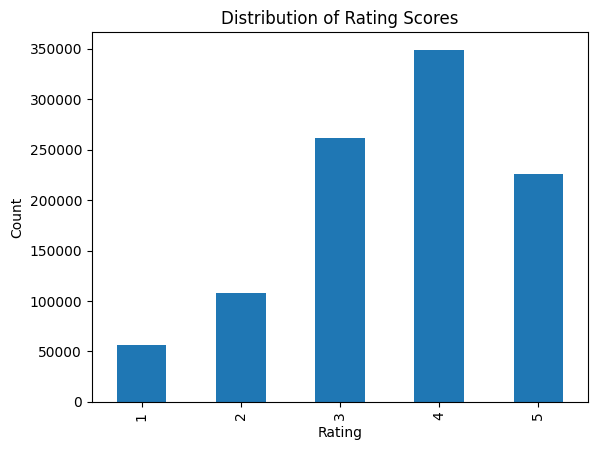

In [53]:
%matplotlib inline

# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating Scores')
plt.ylabel('Count')

We further separate this by the director's gender to compare the proportion of ratings between male versus female directors. Male directors received a greater proportion of 5 star ratings. This leads us to define the rating of 5 stars as a high rating, using this to identify bias in the next section to determine whether male-directed movies are advantaged by our model to receive a prediction of 5 stars.

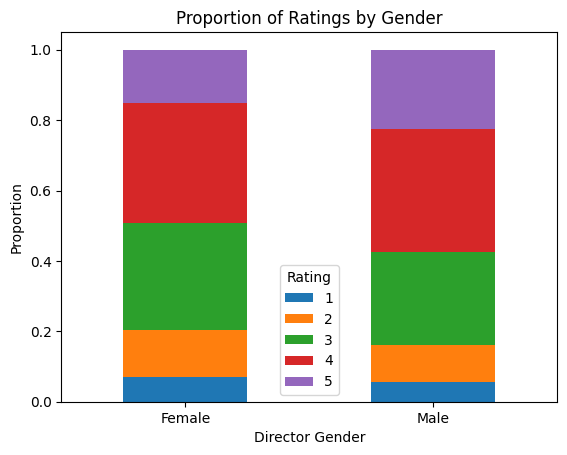

In [54]:
# Set 'director_gender' as index
Ratings_and_Movies_indexed = Ratings_and_Movies.set_index('director_gender')

# Group by 'director_gender' and 'user_rating', and count occurrences
rating_counts_by_gender = Ratings_and_Movies.groupby(['director_gender', 'user_rating']).size().unstack()

# Normalize by the total number of ratings for each gender
rating_percentage_by_gender = rating_counts_by_gender.div(rating_counts_by_gender.sum(axis=1), axis=0)

# Plotting
ax = rating_percentage_by_gender.plot(kind='bar', stacked=True)

# Set custom x-axis labels
ax.set_xticklabels(['Female', 'Male'], rotation=0)

# Set custom legend
plt.legend(title='Rating')

plt.title('Proportion of Ratings by Gender')
plt.xlabel('Director Gender')
plt.ylabel('Proportion')

plt.show()

Next, we check for gender imbalance in our dataset. Given societal context, we expect most movies to be directed by males. This is reflected in our dataset with a severe imbalance between the proportion of movies directed by males versus females.

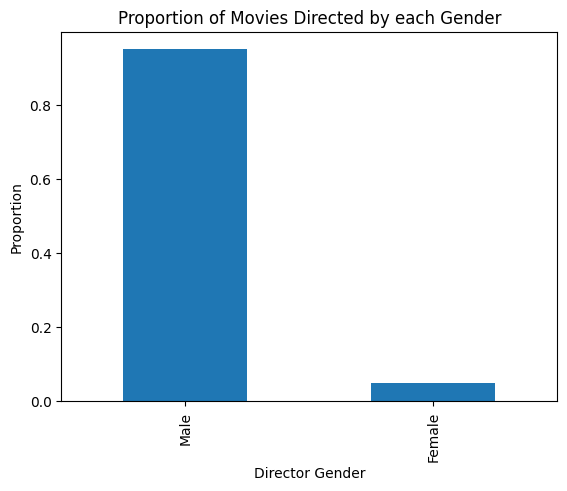

In [30]:
# Proportion of movies in dataset directed by each gender
gender_labels = Ratings_and_Movies['director_gender'].map({1: 'Male', 0: 'Female'})
props = gender_labels.value_counts() / gender_labels.value_counts().sum()
plot = props.plot(kind='bar')
plt.xlabel('Director Gender')
plt.ylabel('Proportion')
plt.title('Proportion of Movies Directed by each Gender')
    
plt.show()

While it is important to acknowledge the strong class imbalance within the dataset, training a linear regression model to predict movie ratings did not reveal a substantial discrepancy in accuracy between male-directed and female-directed movies. 

The model demonstrated comparable performance in predicting ratings for both director genders. The mean squared error (MSE) for predicting ratings of female-directed movies was only slightly lower than that for male-directed movies. There is not a significant difference in accuracy between the different director genders.

Because of this similar performance in model accuracy across director genders, plus the time-constraints of the project and limited resources, we decide not to correct the class imbalance. This imbalance does not significantly impact the predictive capabilities of the linear regression model.

In [52]:
# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Select common features
common_features = ['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
            'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion','male_director_proportion']

# Filter data for male directed movies and female directed movies separately
df_male_director = Ratings_and_Movies[Ratings_and_Movies['director_gender'] == 1]
df_female_director = Ratings_and_Movies[Ratings_and_Movies['director_gender'] == 0]

# Function to train and evaluate a model
def train_and_evaluate(data, director_gender):
    X = data[common_features]
    y = data['user_rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {director_gender}: {mse}')

# Train and evaluate models for male directed movies vs female directed movies
train_and_evaluate(df_male_director, 'Male Directed Movies')
train_and_evaluate(df_female_director, 'Female Directed Movies')

Mean Squared Error for Male Directed Movies: 1.1695391357215665
Mean Squared Error for Female Directed Movies: 1.1385471627402086


Our model utilizes features such as the genre of the movie and year to determine whether a user is likely to give that movie a high rating, based on their previous ratings for movies of similar features. So, we examine the distribution of how movie genres and years compare across the different director genders.

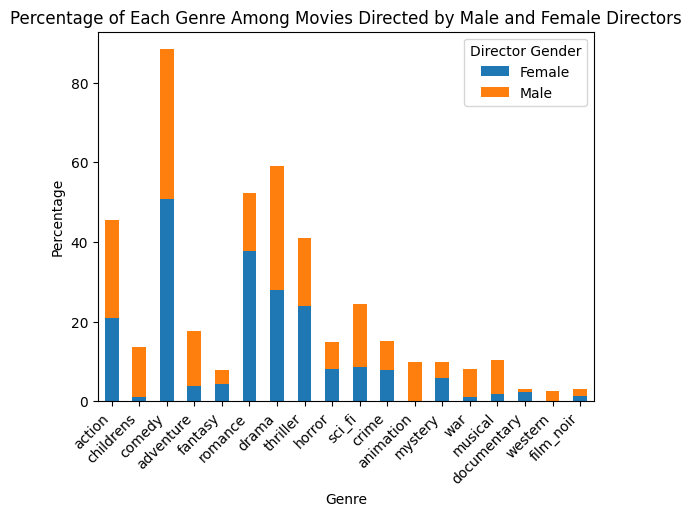

In [31]:
# Group by 'director_gender' and calculate sum of genre columns
genre_counts_by_gender = Ratings_and_Movies_indexed.groupby(level=0)[['action', "childrens", 'comedy', 'adventure', 'fantasy', 'romance', 'drama', 'thriller', 'horror', 'sci_fi', 'crime', 'animation', 'mystery', 'war', 'musical', 'documentary', 'western', 'film_noir']].sum()

# Calculate total movies by gender
total_movies_by_gender = Ratings_and_Movies_indexed.index.value_counts()

# Calculate percentages
genre_percentage_by_gender = genre_counts_by_gender.div(total_movies_by_gender, axis=0) * 100

# Plotting
ax = genre_percentage_by_gender.transpose().plot(kind='bar', stacked=True)

# Set custom x-axis labels
ax.set_xticks(range(len(genre_percentage_by_gender.columns)))
ax.set_xticklabels(genre_percentage_by_gender.columns, rotation=45, ha='right')

# Set custom legend
plt.legend(title='Director Gender', labels=['Female', 'Male'])

plt.title('Percentage of Each Year Among Movies Directed by Male and Female Directors')
plt.xlabel('Year')
plt.ylabel('Percentage')

plt.show()

Certain genres, such as animation and western, are dominated by male directors. Users who predominantly rate movies within these genres are likely to receive higher predicted ratings for male-directed movies due to the disproportionate representation of male directors.

We also examine the breakdown of gender director across the movies' years.

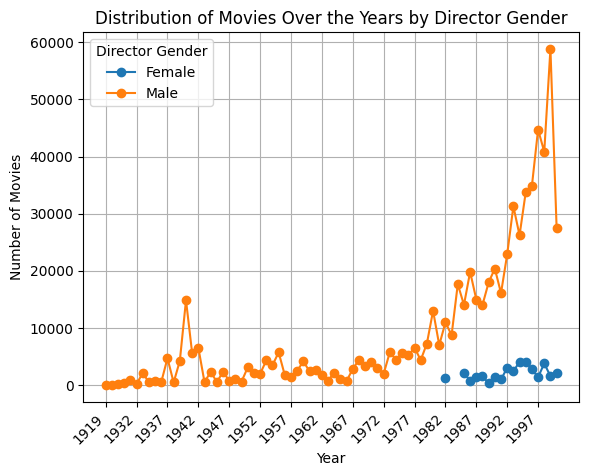

In [45]:
# Group by 'director_gender' and 'year', and count occurrences
year_counts_by_gender = Ratings_and_Movies.groupby(['director_gender', 'year']).size().unstack()

# Plotting
ax = year_counts_by_gender.transpose().plot(kind='line', marker='o')

# Set custom x-axis labels
x_labels = year_counts_by_gender.columns[::5]  # Show every 5th year
ax.set_xticks(range(0, len(year_counts_by_gender.columns), 5))
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Set custom legend
legend_labels = {0: 'Female', 1: 'Male'}  # Custom legend labels
handles, labels = ax.get_legend_handles_labels()
custom_legend = ax.legend(handles, [legend_labels[int(label)] for label in labels], title='Director Gender')

plt.title('Distribution of Movies Over the Years by Director Gender')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

plt.grid(True)  # Add gridlines for better readability

plt.show()

There is a higher representation of male directors across all years, and an absence of female directors in the dataset until the latter half. With male directors dominating the dataset throughout the years, the model may underestimate predictive ratings for movies directed by women.

While the accuracy is comparable across the different director genders, we now look into fairness. We know that the model does not perform significantly better for male directors versus female directors, but as seen in the rating breakdown by director gender, we are inclined to believe male directors will receive higher predictions for a perfect rating of 5.

## Checking for Bias

#### Remove non-numerical column (title) to make dataset compatible with AIF360

We remove the title of the movie because it is not relevant to our model.

In [48]:
Ratings_and_Movies = Ratings_and_Movies.drop('title', axis=1)

In our model, we designate a perfect rating of 5 as the favorable outcome, for the reasons mentioned above. Given the societal context of gender disparities, we acknowledge male directors as the privileged group within our analysis.

In [49]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['male_director_proportion']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(Ratings_and_Movies, label_name='user_rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for User_Gender (e.g., male is privileged)

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'male_director_proportion': 0}],
                                         privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'male_director_proportion': 0}], privileged_groups=[{'male_director_proportion': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'male_director_proportion': 0}],
                                        privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)
print("Statistical Parity Difference After Mitigation:", metric_after.statistical_parity_difference())

Disparate Impact Before Mitigation: 0.6631799095216503
Statistical Parity Difference Before Mitigation: -0.07672487054948571
Disparate Impact After Mitigation: 0.9999999999999997
Statistical Parity Difference After Mitigation: -8.326672684688674e-17


### Disparate Impact:
- A Disparate Impact value of 0.6631799095216503 (before mitigation) shows an imbalance in the favorable outcome (perfect rating of 5) between male and female directors within the dataset. Male directors, as the privileged group, are more likely to achieve the favorable outcome compared to female directors.
- The 3/4ths rule (the fraction 3/4 maps to a percentage of 75%) is a standard threshold used for disparate impact analysis. According to this rule, if the favorable outcome rate for a group is less than 75%, bias is present in the dataset.
- Our Disparate Impact value of 0.6631799095216503 maps to a percentage of 66.3%, which is less than 75%. Female-directed movies are getting 5-star ratings about 66.3% as often as male-directed movies. Since this is less than 75%, there is a bias in how 5-star ratings are distributed between male versus female directed movies.

### Statistical Parity:
- A Statistical Parity Difference value of -0.07672487054948571 (before mitigation) indicates a difference in the proportion of favorable outcomes (perfect ratings of 5) between male and female directors. The negative value suggests that female directors experience a lower rate of favorable outcomes compared to male directors. It implies that male-directed movies receive a higher proportion of 5-star ratings than female-directed movies.
- A Statistical Parity Difference close of 0 shows no difference in the proportion of favorable outcomes between different groups. Our value is close to 0 and does not show a discernible bias.

### Built Recommender System for Recommending Top 5 Movies to Users Based on Jaccard Similarity

In [ ]:
# Create a Movie-User matrix
movie_user_matrix = df.pivot_table(index='movieid', columns='userid', values='user_rating', fill_value=0)

# Function to calculate Jaccard similarity between two movies
def calculate_jaccard_similarity(movie1, movie2):
    intersection = sum((movie1 > 0) & (movie2 > 0))
    union = sum((movie1 > 0) | (movie2 > 0))
    
    if union == 0:
        return 0
    
    return intersection / union

# Function to generate movie recommendations based on Jaccard similarity
def generate_movie_recommendations(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movieid'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Jaccard_Score'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

### Find top 5 movies for any given user ID

In [ ]:
# Example: Recommend top 5 movies for User ID 1
user_id_to_recommend = 1
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, df[['movieid']], top_n=5)

print(f"Top 5 Recommended Movies for User ID {user_id_to_recommend}:\n", recommended_movies)

### Plotted director gender proportion of top 5 movies recommended to user

In [ ]:
# Calculate mean male director proportion of recommended movies
mean_male_director_proportion = df[df['movieid'].isin(list(recommended_movies['movieid']))].drop_duplicates(subset='movieid')['male_director_proportion'].mean()

# Calculate female director proportion
mean_female_director_proportion = 1 - mean_male_director_proportion

# Data for the pie chart
labels = ['Male Director', 'Female Director']
sizes = [mean_male_director_proportion, mean_female_director_proportion]

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Average Proportion of Director Gender of Recommended Movies')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding legend and labels
plt.legend()

# Show plot
plt.show()

### Plotted director gender proportion based on user's watch history

In [ ]:
# Average male director proportion of movies watched by user
mean_male_director_proportion = df[df['userid'] == user_id_to_recommend]['male_director_proportion'].mean()

# Calculate female director proportion
mean_female_director_proportion = 1 - mean_male_director_proportion

# Data for the pie chart
labels = ['Male Director', 'Female Director']
sizes = [mean_male_director_proportion, mean_female_director_proportion]

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Average Proportion of Director Gender of User's Watch History")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding legend and labels
plt.legend()

# Show plot
plt.show()